--- FIXING SENTIMENT MATCH (REMOVING IDs) ---
Cleaning names...
Merging...
-> SUCCESS: Matched 12,920 rows.
-> Updated '7_enhanced_training_set.csv'.
-> Chart saved as 'sentiment_impact_chart.png'.


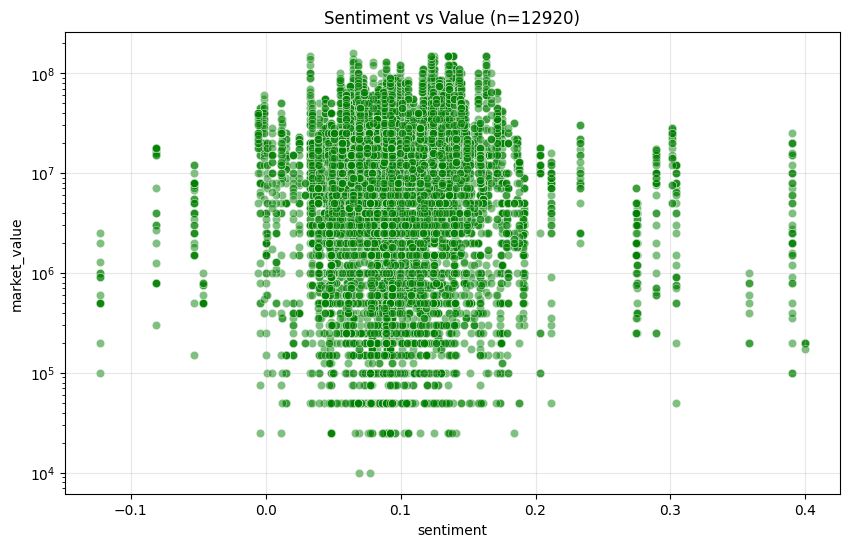

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

print("--- FIXING SENTIMENT MATCH (REMOVING IDs) ---")

# 1. Load Data
df_train = pd.read_csv('7_enhanced_training_set.csv')
df_sentiment = pd.read_csv('4_master_sentiment.csv')

# 2. Clean Training Names (Remove the " (123)" part)
# Function: Look for a space, parenthesis, digits, parenthesis at end of string
def clean_player_name(name):
    name = str(name).lower().strip()
    # Remove " (123)" pattern
    name = re.sub(r'\s*\(\d+\)$', '', name)
    return name

print("Cleaning names...")
# Clean Training Set Names (e.g., "Silvio Adzic (1)" -> "silvio adzic")
df_train['name_clean'] = df_train['player_name'].apply(clean_player_name)

# Clean Sentiment Names (e.g., "AARON CRESSWELL" -> "aaron cresswell")
df_sentiment['name_clean'] = df_sentiment['player_name'].astype(str).str.lower().str.strip()

# 3. Force Merge
print("Merging...")
# Create a dictionary: {'aaron cresswell': 0.304, ...}
sentiment_map = pd.Series(df_sentiment.sentiment.values, index=df_sentiment.name_clean).to_dict()

# Map values
df_train['sentiment'] = df_train['name_clean'].map(sentiment_map).fillna(0)

# Check matches
matched_count = len(df_train[df_train['sentiment'] != 0])
print(f"-> SUCCESS: Matched {matched_count:,} rows.")

# 4. Save and Plot
if matched_count > 0:
    # Drop temp col and Save
    df_train.drop(columns=['name_clean'], inplace=True)
    df_train.to_csv('7_enhanced_training_set.csv', index=False)
    print("-> Updated '7_enhanced_training_set.csv'.")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.yscale('log')
    sns.scatterplot(data=df_train[df_train['sentiment']!=0], x='sentiment', y='market_value', alpha=0.5, color='green')
    plt.title(f'Sentiment vs Value (n={matched_count})')
    plt.grid(True, alpha=0.3)
    plt.savefig('sentiment_impact_chart.png')
    print("-> Chart saved as 'sentiment_impact_chart.png'.")
else:
    print("[CRITICAL] Matches are still 0. Please send a screenshot of the first 5 rows of df_train['player_name'].")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

print("--- FINAL PIPELINE RUN  ---")

# 1. Load Enhanced Data
df = pd.read_csv('7_enhanced_training_set.csv')

# 2. Separate Features (X) and Target (y)
X = df.drop(columns=['market_value', 'player_id', 'player_name', 'date'])
y = df['market_value']

#-- Fixing the outlier --
# --- THE FIX IS HERE ---
# Replace Infinity (inf) with 0
print("Fixing infinite values...")
X.replace([np.inf, -np.inf], 0, inplace=True)
# -----------------------

# 3. Define Feature Lists
numeric_features = [
    'goals', 'assists', 'minutes_played', 'yellow_cards', 
    'total_days_injured', 'sentiment',
    'value_momentum', 'value_lag_1', 'value_lag_2'
]
categorical_features = ['position', 'country_of_birth']

# 4. Build Pipelines
numeric_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=0), 
    StandardScaler()
)

categorical_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='Unknown'), 
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

# 5. Transform
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_features),
    (categorical_pipe, categorical_features),
    remainder='drop'
)

print("Scaling data... (This creates the final AI input)")
X_processed = preprocessor.fit_transform(X)

# 6. Save Final File
# Get feature names
new_columns = (numeric_features + 
               list(preprocessor.named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names_out()))

df_final = pd.DataFrame(X_processed, columns=new_columns)
df_final['market_value'] = y.values # Add target back

df_final.to_csv('8_FINAL_TRAINING_DATA_V2.csv', index=False)
print(f"-> DONE. Saved '8_FINAL_TRAINING_DATA_V2.csv'.")
print(f"-> This file is ready for LSTM Training.")

--- FINAL PIPELINE RUN (FIXED INFINITY ERROR) ---
Fixing infinite values...
Scaling data... (This creates the final AI input)
-> DONE. Saved '8_FINAL_TRAINING_DATA_V2.csv'.
-> This file is ready for LSTM Training.
